In [2]:
# OS import
import os
import re
import datetime
import lxml
import requests
# Math
import pandas as pd
import numpy as np
# Data Visiualization
import matplotlib.pyplot as plt
import plotly.express as px
# APIs
from fredapi import Fred

In [3]:
FRED_KEY = os.environ.get('FRED_KEY')
Fred_handler = Fred(api_key=FRED_KEY)

In [4]:
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Searching

In [5]:
homeowner_race = Fred_handler.search(text='Home ownership rates by race', order_by='popularity')
horace = {}
for seri in homeowner_race.index:
    horace[seri] = Fred_handler.get_series(seri)
horace_df = pd.concat(horace, axis=1)

homeowner_race['title'] = homeowner_race['title'].str.replace('Homeownership Rates by Race and Ethnicity:', '')
homeowner_race['title'] = homeowner_race['title'].str.replace(' Alone in the United States', '')
id_to_ethnic = homeowner_race['title'].to_dict()

homeowner_race_df = pd.concat(horace, axis=1)
homeowner_race_df.columns = [id_to_ethnic[c] for c in homeowner_race_df.columns]

<AxesSubplot:>

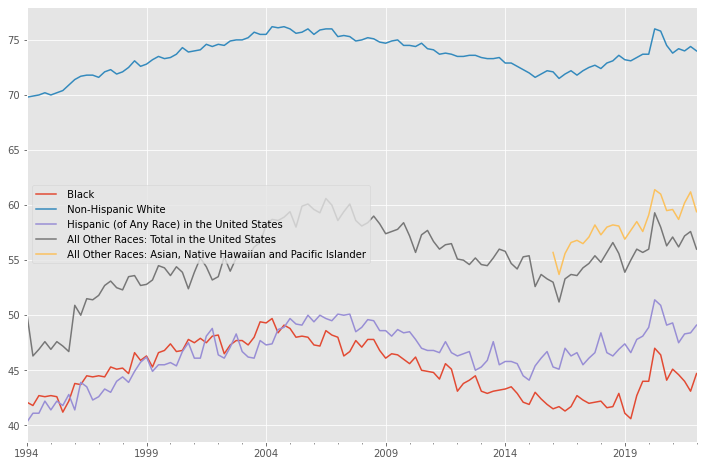

In [6]:
homeowner_race_df.plot(figsize=(12,8))

In [7]:
res = Fred_handler.search(text='Housing State', order_by='popularity')

In [8]:
res = res.loc[res['title'].str.contains('All-Transactions House Price Index for ')]
res['title'] = res['title'].str.replace('All-Transactions House Price Index for ', '')
res=res.loc[res.index.str.contains('THPI')]

In [9]:
_dict = {}
for i in res.index:
    _dict[i] = Fred_handler.get_series(i)
df_usstates_transactions = pd.concat(_dict, axis=1)

In [10]:
id_to_title = {}
for i in res.index:
    id_to_title[i] = res['title'][i]
df_usstates_transactions.columns = [id_to_title[c] for c in df_usstates_transactions.columns]

## Pull codes from web

In [11]:
abbr = pd.read_html('https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm')

In [12]:
tdf = pd.concat(abbr)
tdf.columns = tdf.iloc[0]
tdf.drop(0, inplace=True)
tdf.reset_index(inplace=True, drop=True)
tdf.drop(tdf.index[27:], inplace=True)
state_codes = pd.concat((tdf.iloc[:, 0:3], tdf.iloc[:-1, 3:]), ignore_index=True)
state_codes.index = state_codes.State
# Keeping State Double Recorded (df.index, df.column) for plotting readibility
# state_codes.drop('State', axis=1, inplace=True)

In [13]:
state_abbreviations = {}
df_usstates_transactions
df_states_recent = pd.merge(df_usstates_transactions.loc['2022-01-01'], state_codes, left_index = True, right_index=True)
df_states_recent.rename(columns={df_states_recent.columns[0]:'Most Recent'}, inplace=True)

## Plot US States by Most Recent of ALL Transaction House Price Index

In [14]:
df_states_recent.sort_values('Most Recent').tail()

Most Recent          State Postal Abbr. FIPS Code
Hawaii              799.98         Hawaii           HI        15
California          868.30     California           CA        06
New York            878.48       New York           NY        36
Washington          910.83     Washington           WA        53
Massachusetts      1035.47  Massachusetts           MA        25

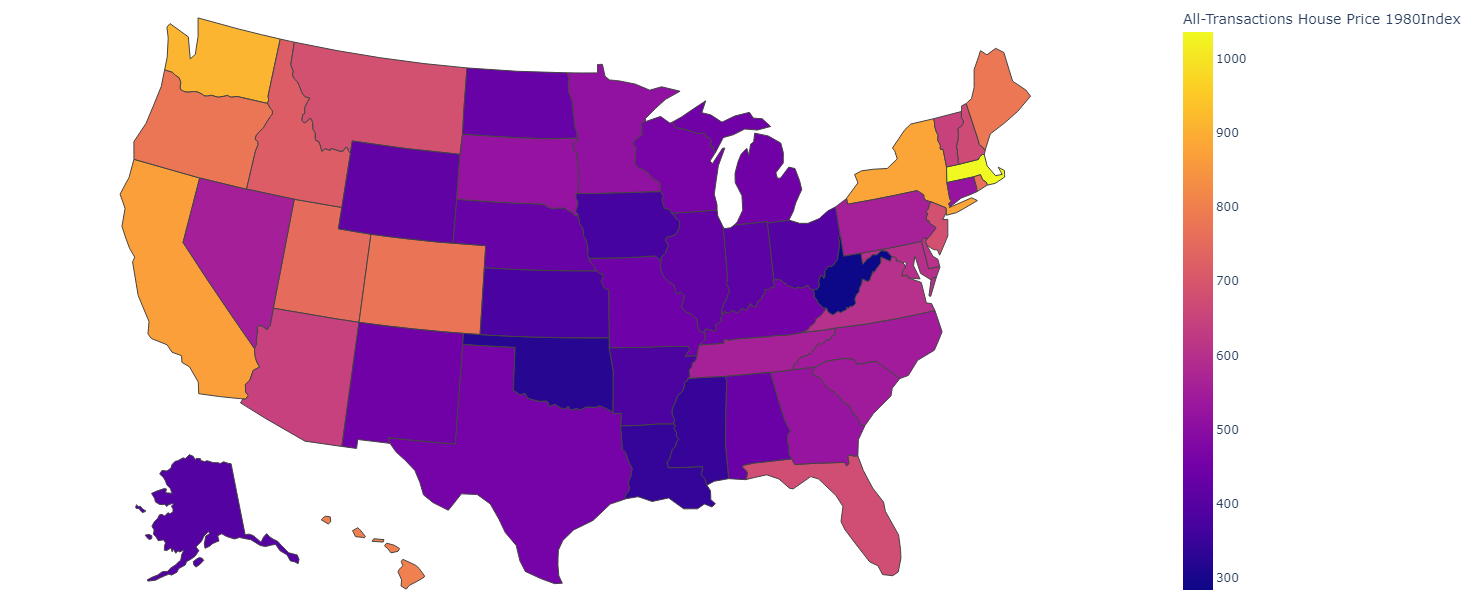

In [15]:
states_geojson = requests.get('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_1_states_provinces_lines.geojson').json()
geojson = px.data.election_geojson()

fig = px.choropleth(data_frame=df_states_recent,
                    locations='Postal Abbr.', locationmode='USA-states',
                    geojson=states_geojson,
                    color='Most Recent',
                    color_continuous_scale =px.colors.sequential.Plasma,
                    scope='usa',
                    hover_name='State',
                    labels={'Most Recent':'All-Transactions House Price 1980Index'},
                   )
fig.update_geos(visible=False)
fig.update_layout(height=600, width=1600, margin={'r':0,'t':0,'l':0,'b':0})
fig.show()

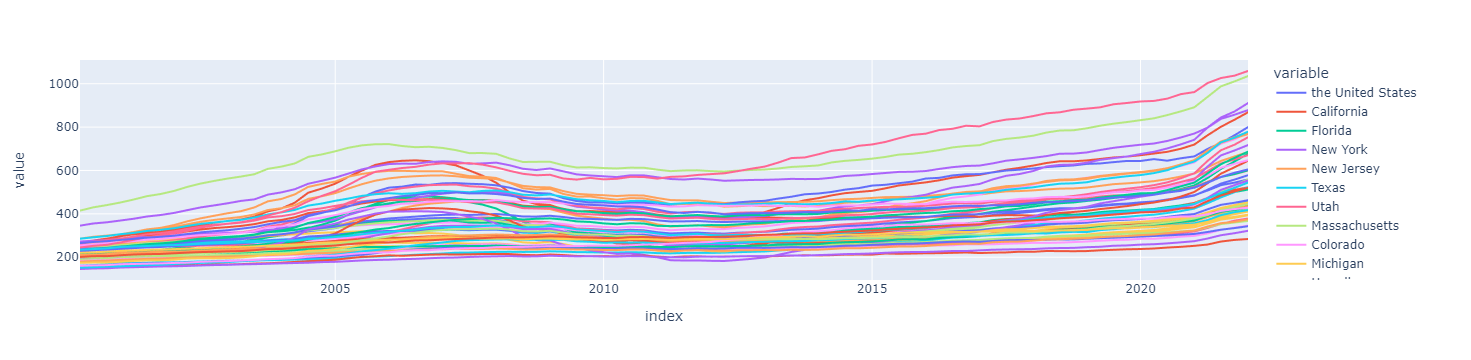

In [16]:
px.line(df_usstates_transactions[df_usstates_transactions.index > '2000'])

In [17]:
residential_by_country = Fred_handler.search('Real Residential country', order_by='popularity')

In [18]:
residential_by_country = residential_by_country.loc[residential_by_country['title'].str.contains('Real Residential Property Prices for')]
residential_by_country['title'] = residential_by_country['title'].str.replace('Real Residential Property Prices for', '')

In [19]:
residential_by_country

id realtime_start realtime_end               title  \
series id                                                                
QUSR628BIS  QUSR628BIS     2022-06-14   2022-06-14       United States   
QKRR628BIS  QKRR628BIS     2022-06-14   2022-06-14   Republic of Korea   
QHKR628BIS  QHKR628BIS     2022-06-14   2022-06-14       Hong Kong SAR   
QDER628BIS  QDER628BIS     2022-06-14   2022-06-14             Germany   
QITR628BIS  QITR628BIS     2022-06-14   2022-06-14               Italy   
...                ...            ...          ...                 ...   
QSKR628BIS  QSKR628BIS     2022-06-14   2022-06-14            Slovakia   
QLUR628BIS  QLUR628BIS     2022-06-14   2022-06-14          Luxembourg   
QSIR368BIS  QSIR368BIS     2022-06-14   2022-06-14            Slovenia   
QLTR368BIS  QLTR368BIS     2022-06-14   2022-06-14           Lithuania   
QLVR368BIS  QLVR368BIS     2022-06-14   2022-06-14              Latvia   

           observation_start observation_end  frequency frequency_short  \
series id                                                                 
QUSR628BIS        1970-01-01      2021-10-01  Quarterly               Q   
QKRR628BIS        1975-01-01      2021-10-01  Quarterly               Q   
QHKR628BIS        1979-10-01      2021-10-01  Quarterly               Q   
QDER628BIS        1970-01-01      2021-10-01  Quarterly               Q   
QITR628BIS        1947-01-01      2021-10-01  Quarterly               Q   
...                      ...             ...        ...             ...   
QSKR628BIS        2006-01-01      2021-10-01  Quarterly               Q   
QLUR628BIS        2007-01-01      2021-10-01  Quarterly               Q   
QSIR368BIS        2008-01-01      2021-10-01  Quarterly               Q   
QLTR368BIS        1999-10-01      2021-10-01  Quarterly               Q   
QLVR368BIS        2007-01-01      2021-10-01  Quarterly               Q   

                        units     units_short      seasonal_adjustment  \
series id                                                                
QUSR628BIS     Index 2010=100  Index 2010=100  Not Seasonally Adjusted   
QKRR628BIS     Index 2010=100  Index 2010=100  Not Seasonally Adjusted   
QHKR628BIS     Index 2010=100  Index 2010=100  Not Seasonally Adjusted   
QDER628BIS     Index 2010=100  Index 2010=100  Not Seasonally Adjusted   
QITR628BIS     Index 2010=100  Index 2010=100  Not Seasonally Adjusted   
...                       ...             ...                      ...   
QSKR628BIS     Index 2010=100  Index 2010=100  Not Seasonally Adjusted   
QLUR628BIS     Index 2010=100  Index 2010=100  Not Seasonally Adjusted   
QSIR368BIS  Percent per Annum     % per Annum  Not Seasonally Adjusted   
QLTR368BIS  Percent per Annum     % per Annum  Not Seasonally Adjusted   
QLVR368BIS  Percent per Annum     % per Annum  Not Seasonally Adjusted   

           seasonal_adjustment_short               last_updated popularity  \
series id                                                                    
QUSR628BIS                       NSA  2022-03-24 11:01:08-05:00         59   
QKRR628BIS                       NSA  2022-04-28 11:02:03-05:00         45   
QHKR628BIS                       NSA  2022-05-26 11:01:07-05:00         43   
QDER628BIS                       NSA  2022-04-28 11:02:03-05:00         41   
QITR628BIS                       NSA  2022-03-24 11:01:13-05:00         37   
...                              ...                        ...        ...   
QSKR628BIS                       NSA  2022-03-24 11:02:05-05:00          1   
QLUR628BIS                       NSA  2022-04-28 11:02:24-05:00          1   
QSIR368BIS                       NSA  2022-04-28 11:02:55-05:00          1   
QLTR368BIS                       NSA  2022-03-24 11:01:59-05:00          1   
QLVR368BIS                       NSA  2022-03-24 11:02:00-05:00          1   

                                                        notes  
series id                              

In [20]:
print(residential_by_country.units.unique())
ser_annum_dict = residential_by_country[residential_by_country['units'] == 'Percent per Annum']['title'].to_dict()
ser_2010_dict = residential_by_country[residential_by_country['units'] == 'Index 2010=100']['title'].to_dict()
# country_annum_df = residential_by_country[residential_by_country['units'] == 'Percent per Annum']
# country_index_df = residential_by_country[residential_by_country['units'] == 'Index 2010=100']

['Index 2010=100' 'Percent per Annum']


In [21]:
resi_dict = {}
for country in residential_by_country.index:
    resi_dict[country] = Fred_handler.get_series(country)
resi_country_df = pd.concat(resi_dict, axis=1)

# Plotting Country Residential Propery Price 
## By Index 2010 = 100
Below we handle Residential Property Price based on Index=2010.<br>
<ul>
    <li>Figure 1: 41 Seperate charts, Red dashed line starts in Jan 2019. Early announcements of COVID</li>
    <li>Figure 2: Interactive Line plot
</ul>

In [22]:
id_to_country = residential_by_country['title'].to_dict()
country_index_df = resi_country_df.T[resi_country_df.apply(lambda x: x.name in ser_2010_dict.keys())].T
country_index_df.columns = [id_to_country[c] for c in country_index_df.columns]
country_index_df.dropna(inplace=True)

In [23]:
country_index_df.head(5)

United States   Republic of Korea   Hong Kong SAR   Germany  \
2010-01-01        102.1880            100.4909         93.4491   99.1405   
2010-04-01        101.0166            100.3644         96.7947   99.8446   
2010-07-01         99.0135             99.4961        104.0607  100.5012   
2010-10-01         97.8017             99.6599        105.6681  100.5060   
2011-01-01         95.7196             99.5045        111.9423  100.1838   

               Italy   Malaysia   Singapore     Spain    Mexico    Turkey  \
2010-01-01   99.6538    96.8586     95.7477  101.3060   98.8179   99.3658   
2010-04-01   99.9677    99.8799     99.6303  101.2193   99.9587   99.6284   
2010-07-01  100.2773   100.7967    101.3334   99.6126  100.8718  100.5713   
2010-10-01  100.0970   102.4224    103.1580   97.9162  100.3425  100.4196   
2011-01-01   98.6254   103.1552    103.5480   94.4117  100.8657  101.4393   

             Portugal    Greece   Switzerland   South Africa    Sweden  \
2010-01-01   101.6862  106.2269       98.3528       100.3992   98.6619   
2010-04-01   100.7250  100.3342       98.3983       100.3799   99.3769   
2010-07-01    99.6735   98.1399      101.1495        99.7025  100.8327   
2010-10-01    97.9585   95.5651      102.1073        99.5307  101.1060   
2011-01-01    95.9450   95.9752      104.8045        98.9766  101.3081   

             New Zealand   United Kingdom   Denmark    Israel   Romania  \
2010-01-01      102.4238          99.8286   99.1487   96.7733  106.3460   
2010-04-01      101.1164         100.3546  100.3592   98.9260  103.9016   
2010-07-01       99.4213         101.5077  100.9150  100.8582   96.6470   
2010-10-01       97.1478          98.3237   99.5699  103.3273   93.5556   
2011-01-01       96.6200          95.1522   97.4073  106.2646   87.7159   

             Euro area   Netherlands   Austria   Morocco    Norway    France  \
2010-01-01     99.9934      101.0185  100.2603   99.2996   97.8581   97.5619   
2010-04-01     99.6390       99.7261   99.5179  101.2882  100.9446   98.6505   
2010-07-01    100.4683      100.1242   99.7654  100.7692  101.1533  101.4767   
2010-10-01     99.9004       99.1442  100.4564   98.6549  100.0397  102.2866   
2011-01-01     99.2336       98.6900  101.9444   99.4728  104.6780  102.1835   

             Hungary    Latvia   Czech Republic   Ireland  \
2010-01-01  102.6162   98.8691         100.4597  106.1877   
2010-04-01  100.3191   97.9777         100.0225  101.7947   
2010-07-01   99.7524  100.3866          99.6366   98.2918   
2010-10-01   97.3738  102.7311          99.8842   93.8251   
2011-01-01   95.3703  105.3416          98.9253   88.8522   

             Russian Federation     Malta   Finland   Lithuania   Belgium  \
2010-01-01             101.6916  101.9142   99.6381     99.1576   99.2586   
2010-04-01             100.5569  100.0845   99.7295    100.5869   99.1893   
2010-07-01              99.5132  103.3552  100.9364     99.6819  100.7650   
2010-10-01              98.3305   94.7511   99.6978    100.5611  100.7703   
2011-01-01              72.6459   96.3270   99.6476    103.5105  100.0476   

              Cyprus   Slovenia   Estonia   Croatia   Slovakia   Luxembourg  
2010-01-01  101.9884   101.6622  100.4538  102.0694   101.2206     101.2364  
2010-04-01  100.1073   100.0198   99.7083   99.6970   100.1314      98.6599  
2010-07-01  100.0560    99.0821  102.4940   99.2110    99.4036      99.7299  
2010-10-01   97.9136    99.2663   97.3936   99.0390    99.2526     100.3852  
2011-01-01   97.3315   104.0580  101.6175   96.9019    96.9183      98.8499

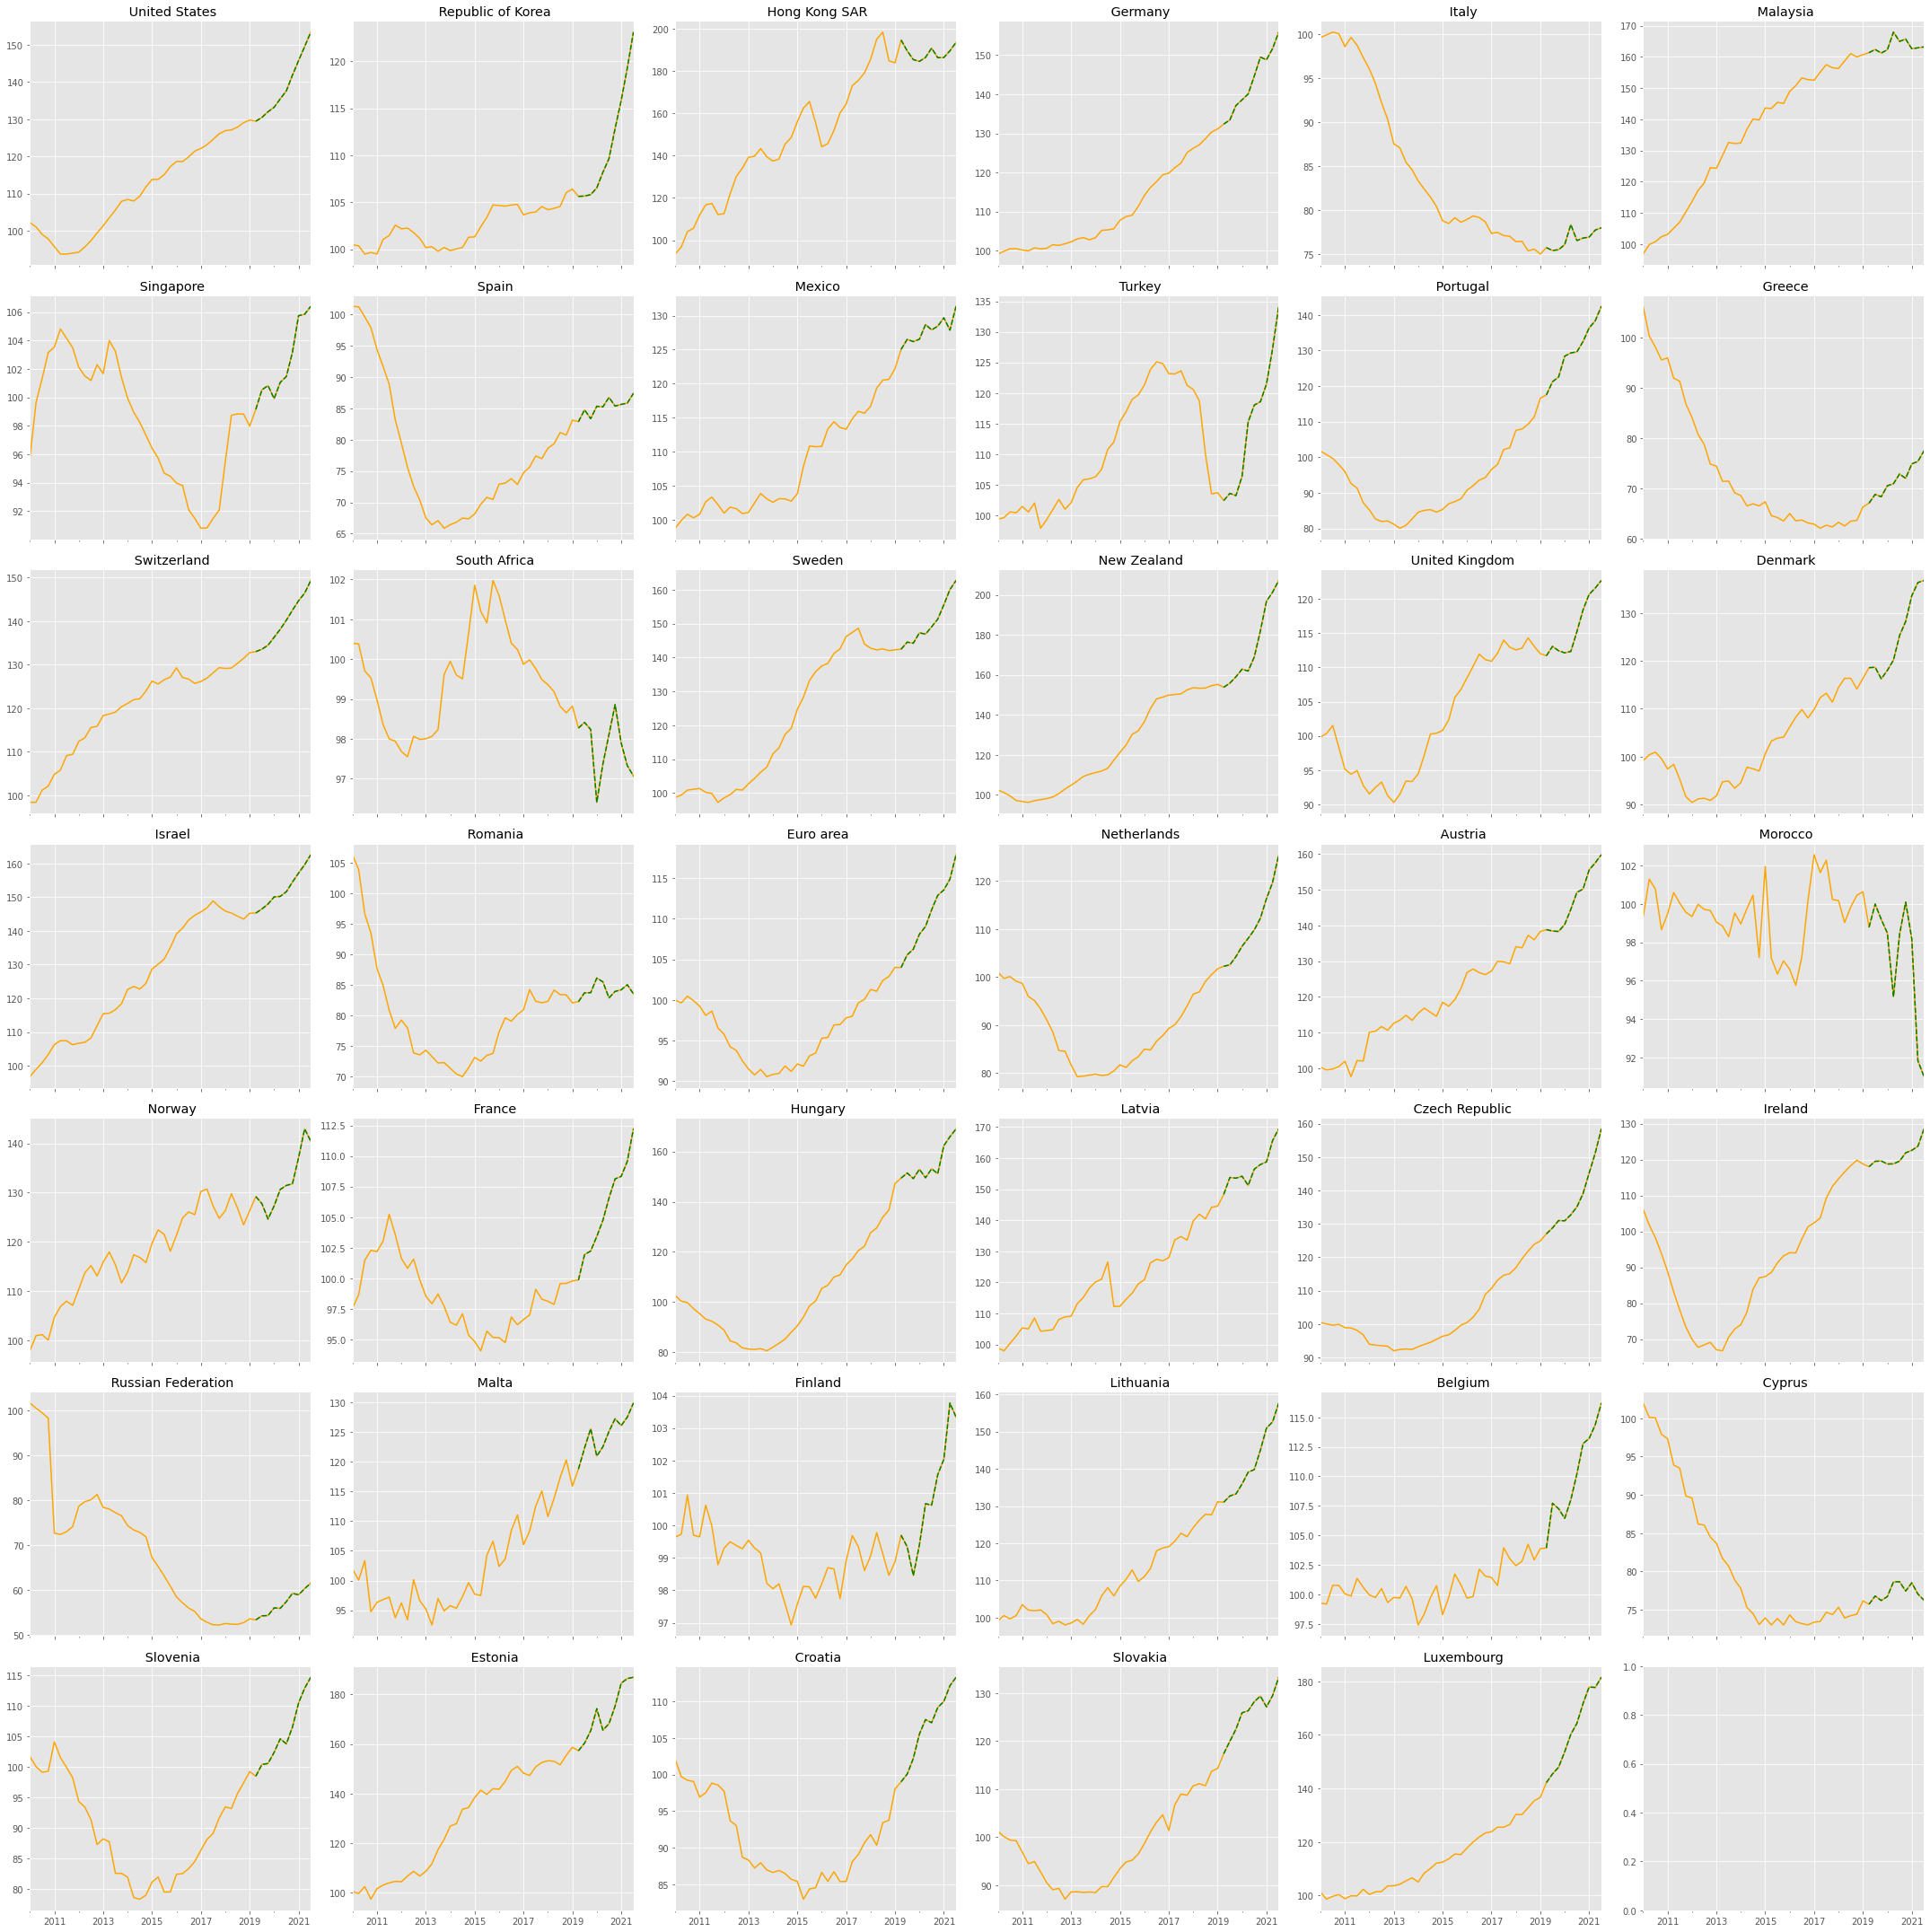

In [24]:
fig, axs = plt.subplots(7,6, figsize=(30,30), sharex=True)
axs = axs.flatten()
for idx, country in enumerate(country_index_df.columns):
    country_index_df[country].plot(ax=axs[idx], color='orange')
    country_index_df[country_index_df.index > '2019'][country].plot(ax=axs[idx], color='green', linestyle='--')
    axs[idx].set_title(country)
plt.tight_layout()
plt.show()

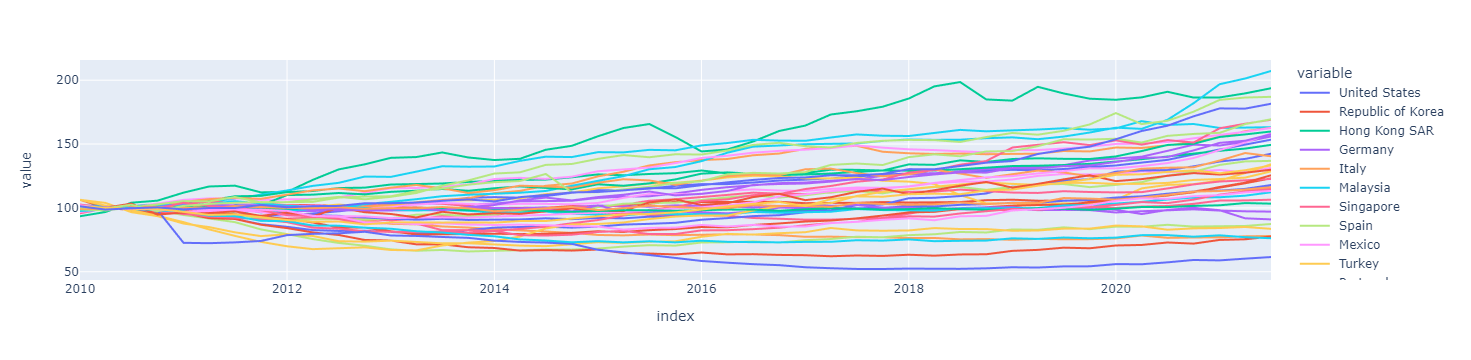

In [25]:
px.line(country_index_df)

In [26]:
country_index_df[country_index_df.index >= '2019'].T.sort_values('2021-07-01', ascending=False)

2019-01-01  2019-04-01  2019-07-01  2019-10-01  \
 New Zealand           155.2219    153.7778    155.8488    159.0308   
 Hong Kong SAR         183.9822    194.8008    189.6288    185.5009   
 Estonia               158.6708    157.3163    160.3650    165.3539   
 Luxembourg            136.6760    142.2081    145.4324    147.9439   
 Latvia                144.5069    148.3204    153.7351    153.5184   
 Hungary               147.2772    149.3897    151.4380    149.1813   
 Malaysia              160.7118    161.3558    162.3719    161.2281   
 Sweden                142.2722    142.4407    144.5396    144.2060   
 Israel                145.2187    145.2854    146.4844    147.9621   
 Austria               138.2774    138.8192    138.4272    138.2961   
 Czech Republic        124.9005    127.0093    128.7843    130.9968   
 Lithuania             131.1385    131.0206    132.7060    133.2458   
 Germany               131.1492    132.3896    133.4452    137.1287   
 United States         129.7810    129.4606    130.4675    132.0054   
 Switzerland           132.7778    133.0158    133.5601    134.4824   
 Portugal              116.5755    117.5135    121.2252    122.5313   
 Norway                126.3705    129.2009    127.7594    124.6364   
 Denmark               116.3419    118.5879    118.6725    116.2524   
 Turkey                103.6900    102.4174    103.5841    103.2244   
 Slovakia              114.3215    117.3971    119.9645    122.4881   
 Mexico                122.2262    125.0465    126.5091    126.1846   
 Malta                 115.9062    118.7833    122.3369    125.5673   
 Ireland               118.8030    118.0356    119.5320    119.6229   
 Netherlands           101.7226    102.2649    102.5420    104.2775   
 Republic of Korea     106.4097    105.6338    105.6667    105.8135   
 United Kingdom        112.0069    111.6996    113.0672    112.4318   
 Euro area             104.0073    103.9984    105.5616    106.2566   
 Belgium               103.8730    103.9371    107.7245    107.2580   
 Slovenia               99.1976     98.4557    100.3694    100.5307   
 Croatia                98.0240     99.0006    100.0466    102.1988   
 France                 99.7798     99.8610    101.9361    102.2275   
 Singapore              97.9771     99.1613    100.5344    100.8302   
 Finland                98.8780     99.6979     99.3384     98.4533   
 South Africa           98.8222     98.2723     98.4112     98.2351   
 Morocco               100.6311     98.7801     99.9893     99.1893   
 Spain                  83.1197     82.8779     84.7735     83.3549   
 Romania                82.0987     82.2977     83.7472     83.7585   
 Italy                  75.0057     75.7359     75.4090     75.4972   
 Greece                 66.3528     67.1180     68.8510     68.3843   
 Cyprus                 76.1534     75.7153     76.7896     76.2045   
 Russian Federation     53.5154     53.2935     54.1923     54.2543   

                     2020-01-01  2020-04-01  2020-07-01  2020-10-01  \
 New Zealand           162.8244    161.8924    168.9748    181.9659   
 Hong Kong SAR         184.6611    186.5493    190.9400    186.4041   
 Estonia               174.2705    165.6087    168.2167    175.3265   
 Luxembourg            153.7440    160.2235    164.3453    171.7028   
 Latvia                154.1509    151.1813    156.4186    157.9013   
 Hungary               152.9059    149.5233    153.1086    151.1723   
 Malaysia              162.2680    167.9340    164.9565    165.7071   
 Sweden                147.2870    146.9059    149.0590    151.3285   
 Israel                150.0777    150.2192    151.6167    154.4850   
 Austria               140.2961    144.5096    149.2772    150.1789   
 Czech Republic        130.9246    132.7234    135.0900    139.0667   
 Lithuania             135.9200    139.0751    139.7961    145.0123   
 Germany               138.5810    140.0819    144.6580    149.4990   
 United States         133.2096    135.4712 

## By Country Percent per Annum

In [27]:
country_annum_df = resi_country_df.T[resi_country_df.apply(lambda x: x.name in ser_annum_dict.keys())].T
country_annum_df.columns = [id_to_country[c] for c in country_annum_df.columns]
country_annum_df.dropna(inplace=True)

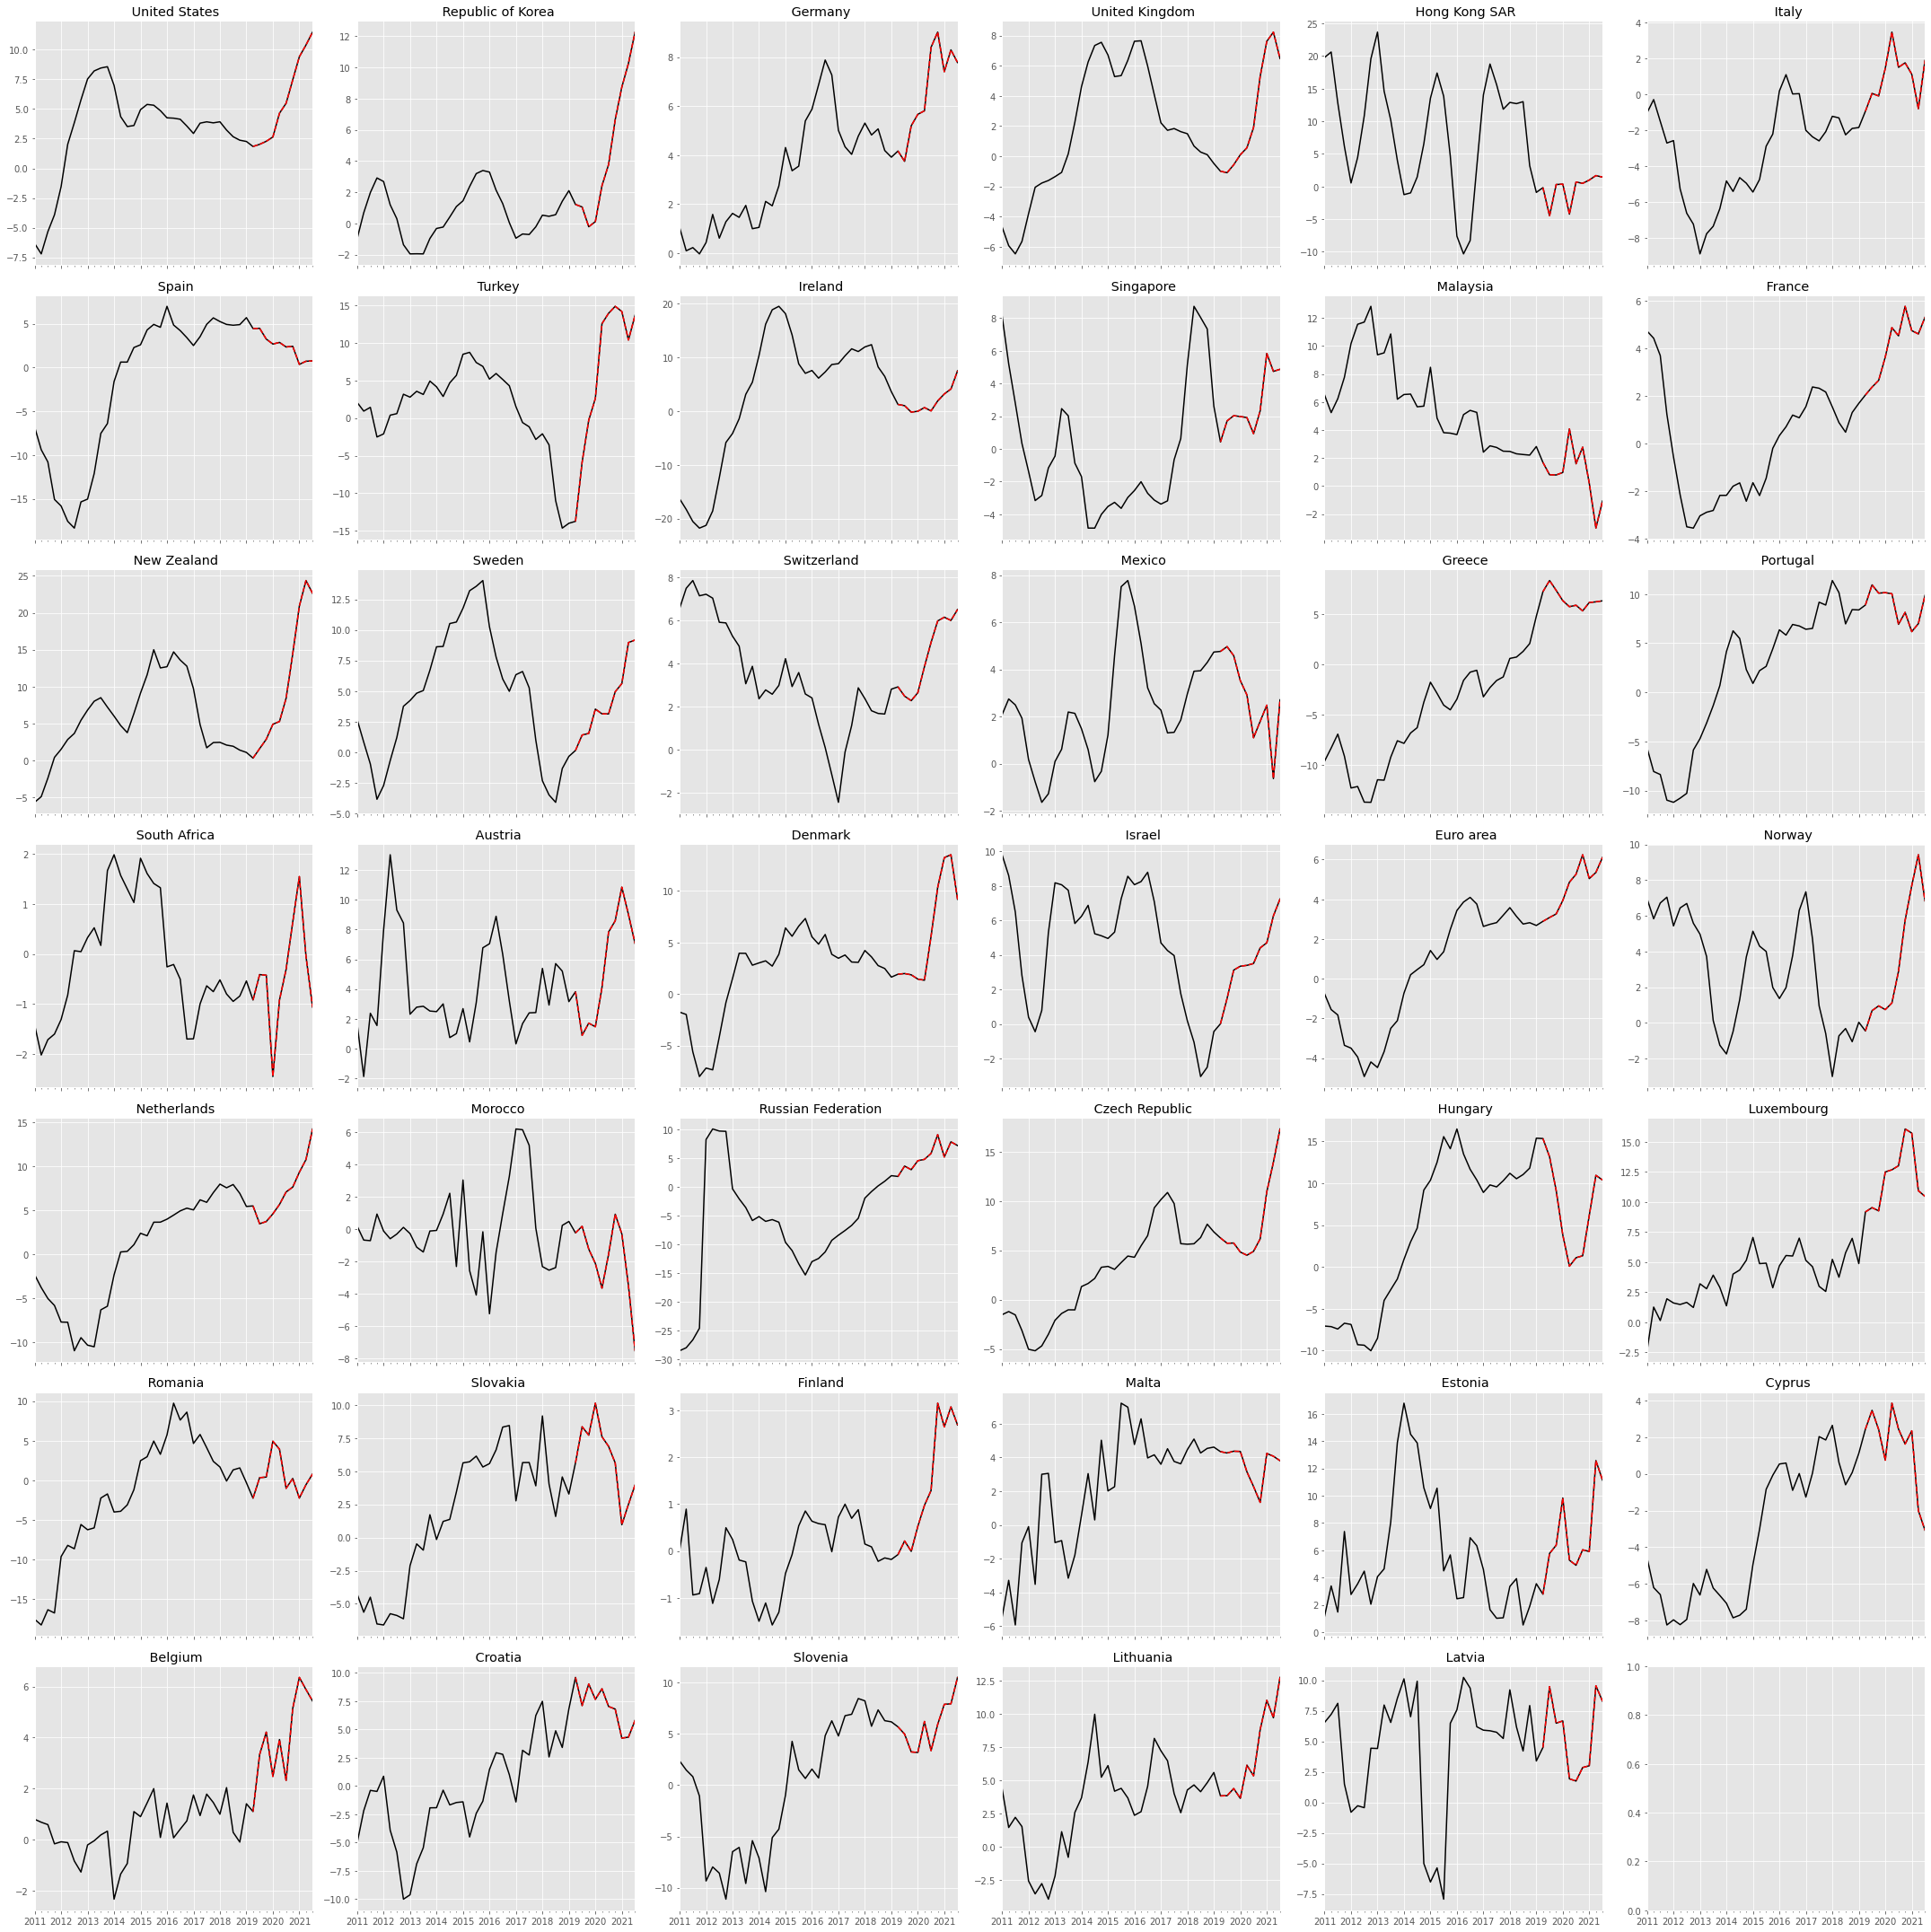

In [28]:
fig, axs = plt.subplots(7,6, figsize=(30,30), sharex=True)
axs = axs.flatten()
for idx, country in enumerate(country_annum_df.columns):
    country_annum_df[country].plot(ax=axs[idx], color='black')
    country_annum_df[country_annum_df.index > '2019'][country].plot(ax=axs[idx], color='red', linestyle='--')
    axs[idx].set_title(country)
plt.tight_layout()
plt.show()

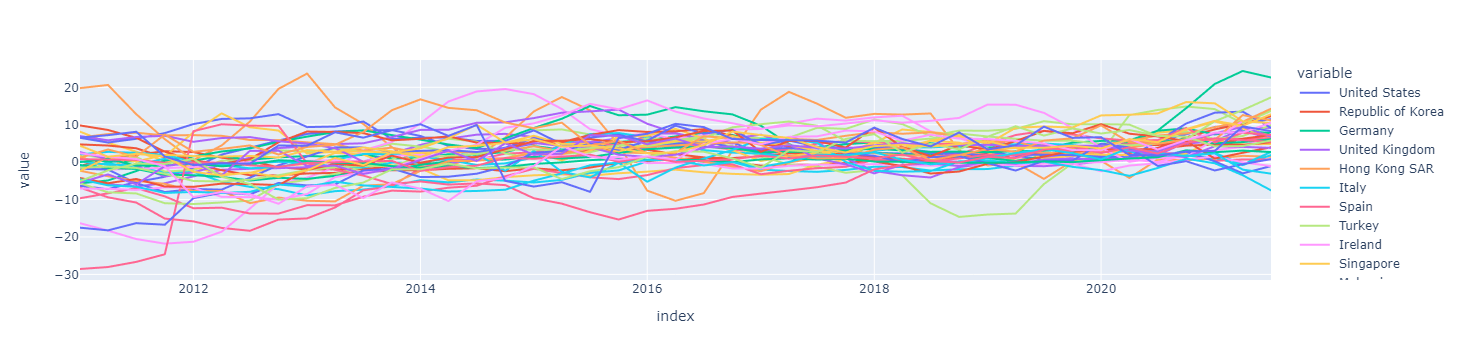

In [29]:
px.line(country_annum_df)

## Combined Index=2010 && Percent per Annum

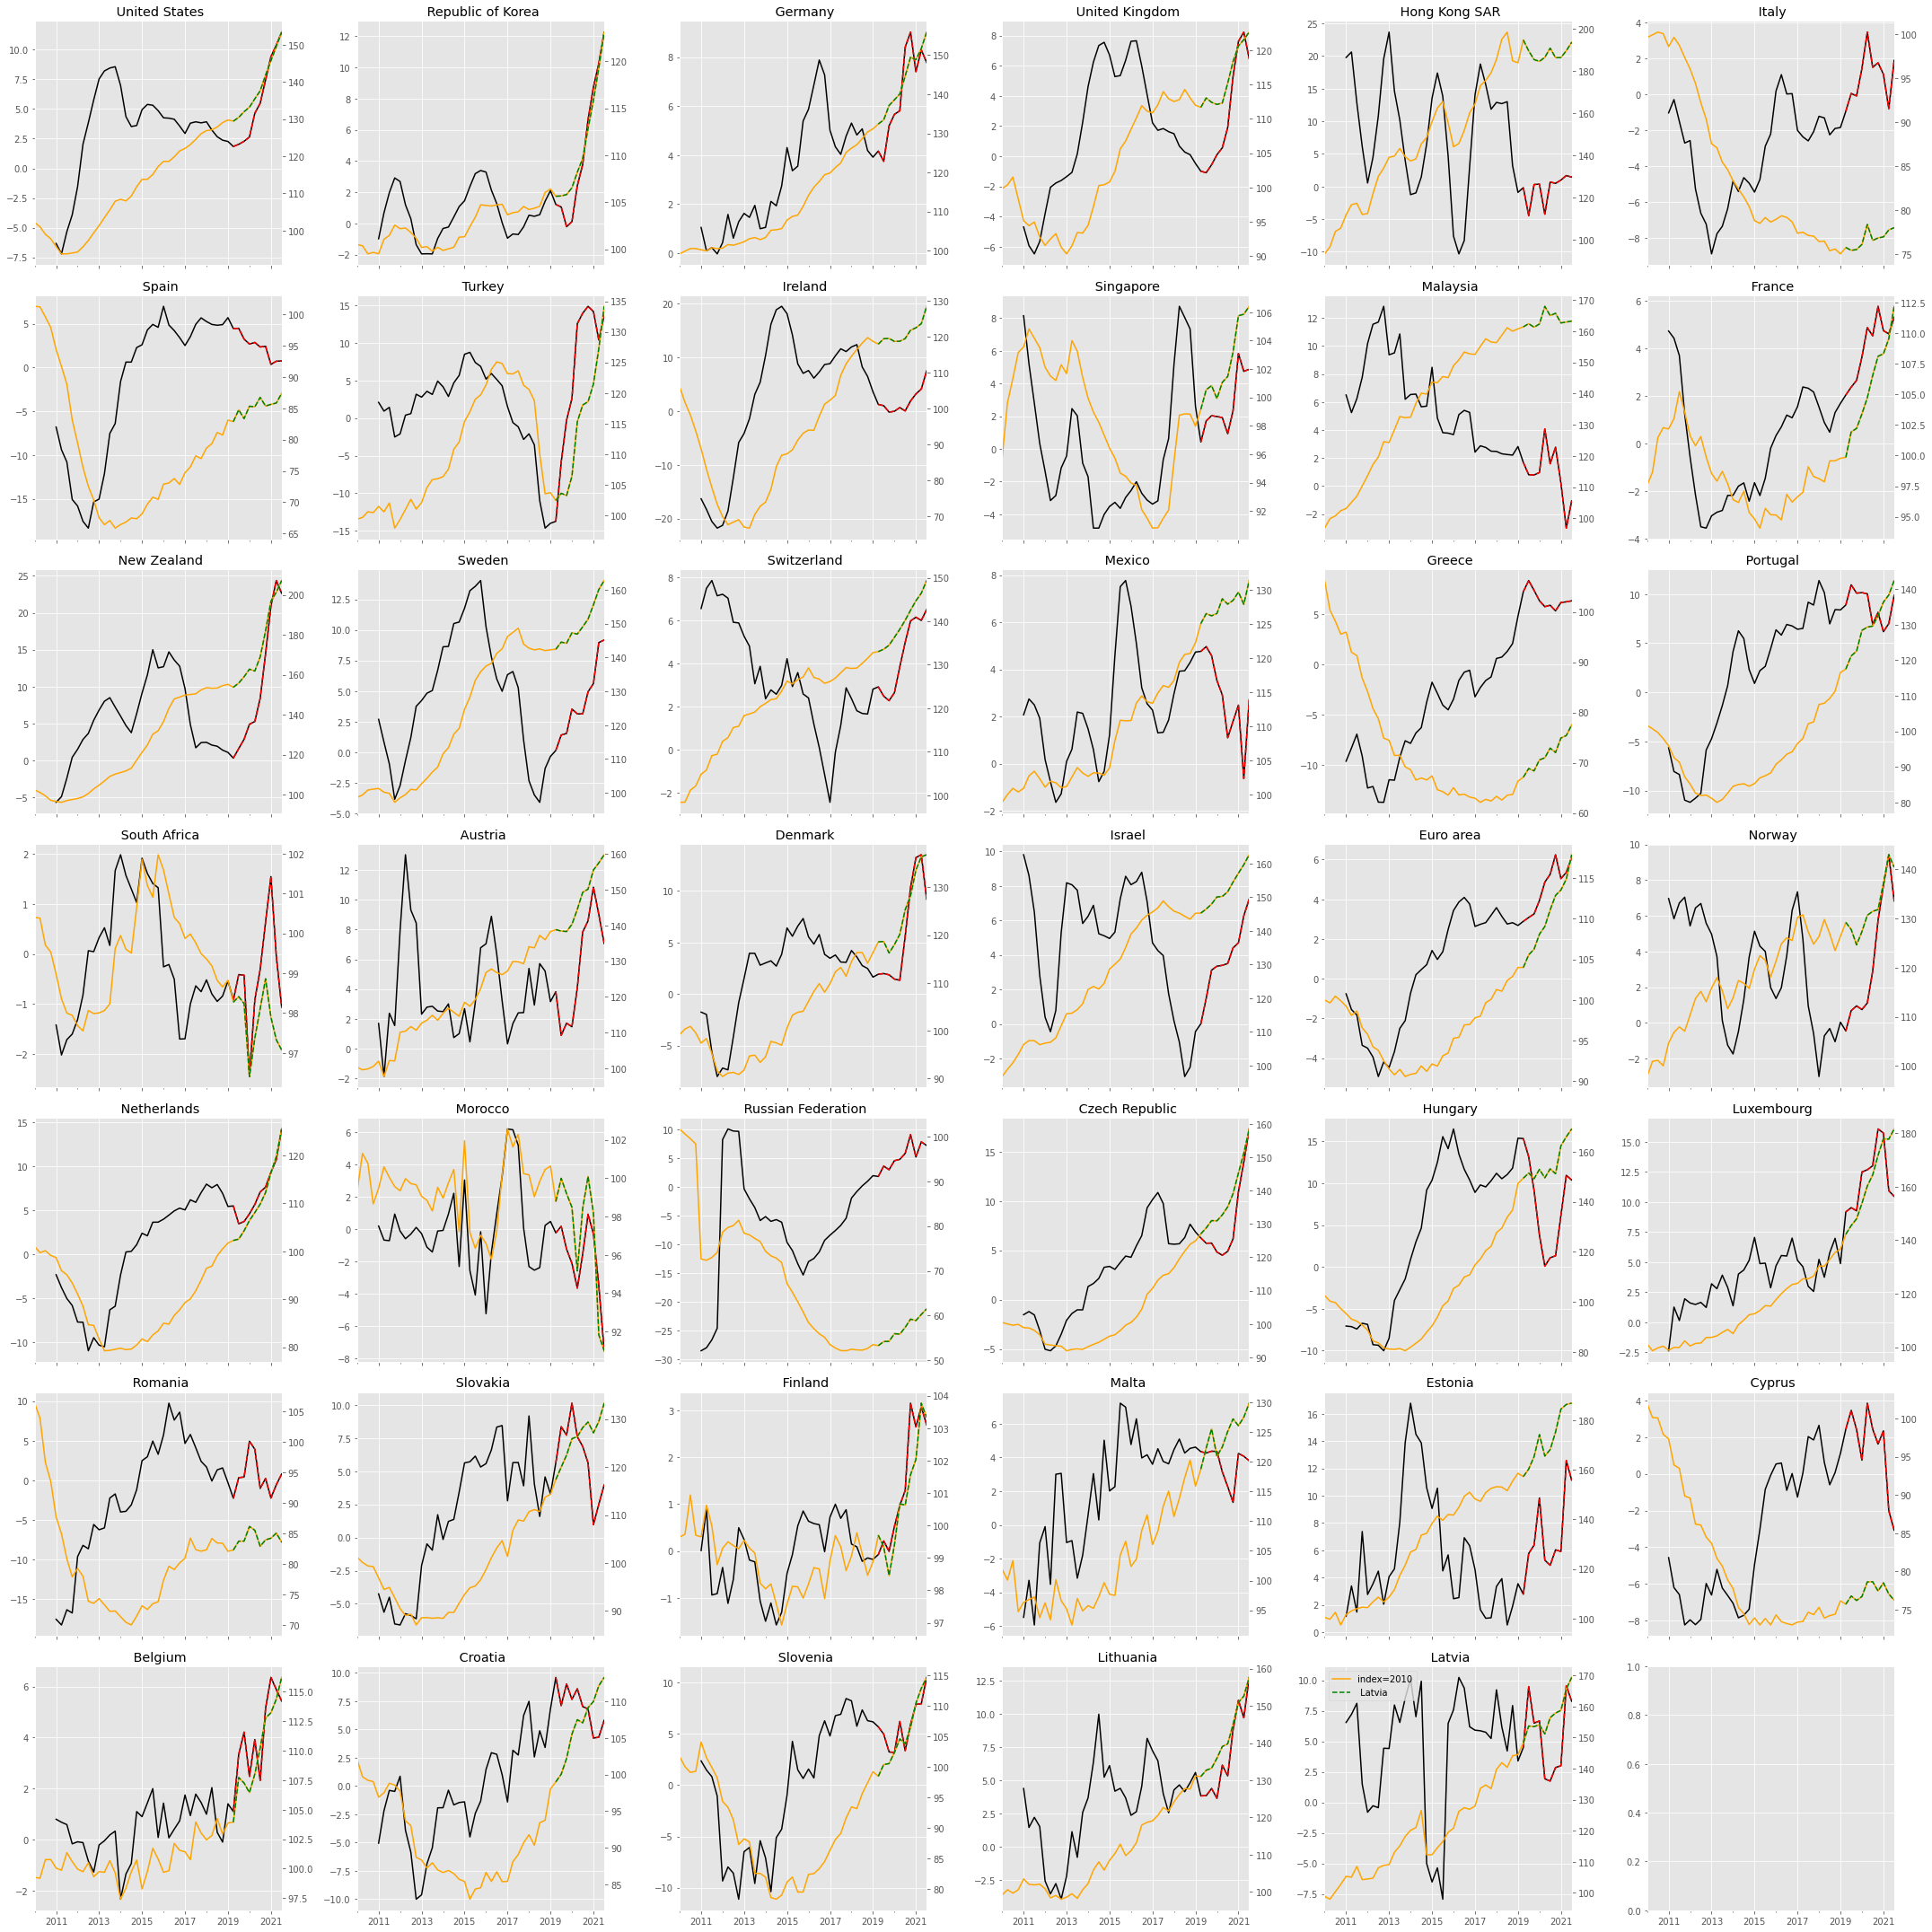

In [30]:
fig, axs = plt.subplots(7,6, figsize=(30,30), sharex=True)
axs = axs.flatten()
for idx, country in enumerate(country_annum_df.columns):
    ax2 = axs[idx].twinx()    
    country_annum_df[country].plot(ax=axs[idx], color='black', label='Per Annum')
    country_annum_df[country_annum_df.index > '2019'][country].plot(ax=axs[idx], color='red', linestyle='--')
    country_index_df[country].plot(ax=ax2, color='orange', label='index=2010')
    country_index_df[country_index_df.index > '2019'][country].plot(ax=ax2, color='green', linestyle='--')
    axs[idx].set_title(country)
    ax2.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

# Geographic Choropleth Mappings
## Index=2010

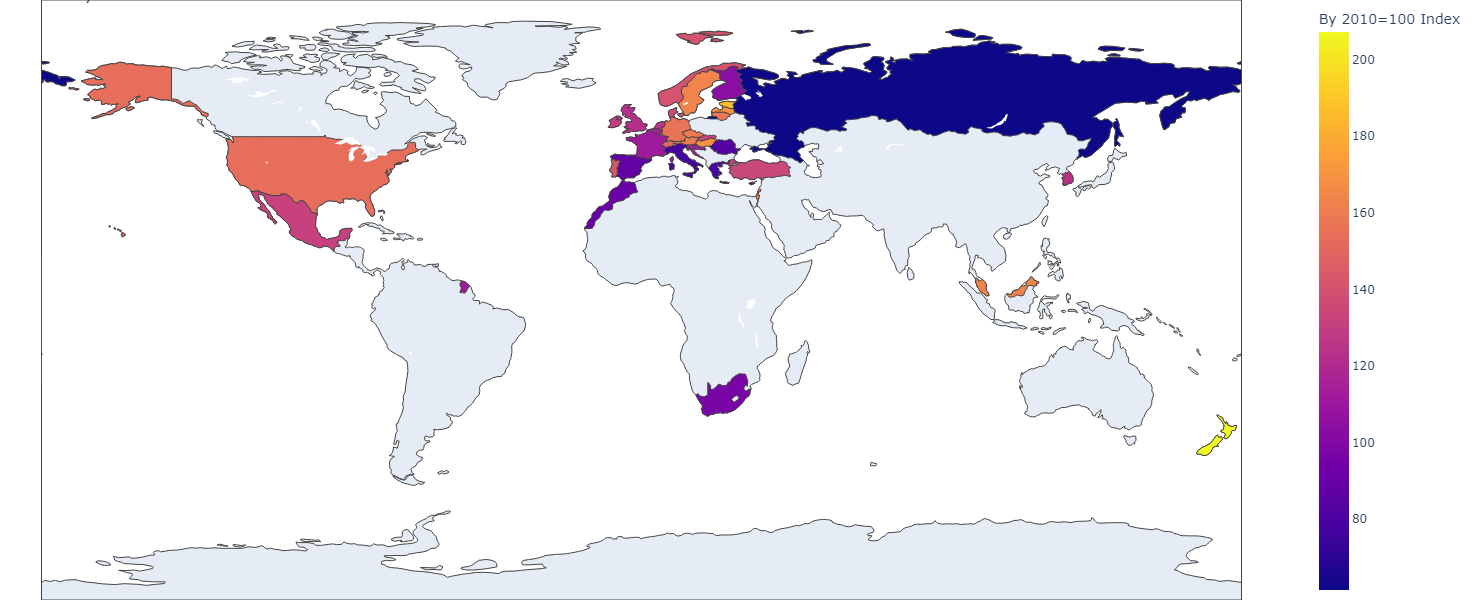

In [31]:
states_geojson = requests.get('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_1_states_provinces_lines.geojson').json()
# countries_geojson = 
geojson = px.data.election_geojson()

fig = px.choropleth(data_frame=country_index_df.T,
                    locations=country_index_df.T.index, locationmode='country names',
                    color='2021-07-01',
                    color_continuous_scale =px.colors.sequential.Plasma, hover_name=country_index_df.T.index,
                    labels={'2021-07-01':'By 2010=100 Index'},
                    title=' by 2010 Index'
                   )
fig.update_layout(height=600, width=1600, margin={'r':0,'t':0,'l':0,'b':0})
fig.show()

## By Country Percent Per Annum

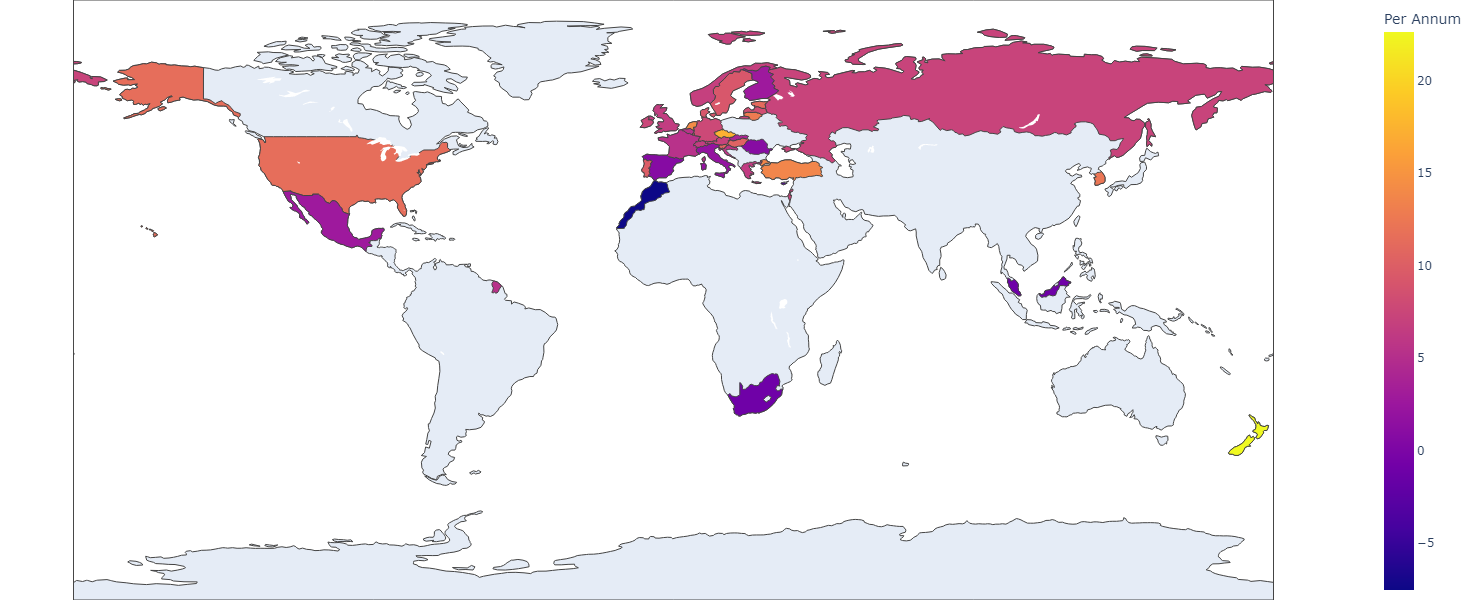

In [32]:
states_geojson = requests.get('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_1_states_provinces_lines.geojson').json()
# countries_geojson = 
geojson = px.data.election_geojson()

fig = px.choropleth(data_frame=country_annum_df.T,
                    locations=country_annum_df.T.index, locationmode='country names',
                    color='2021-07-01',
                    color_continuous_scale =px.colors.sequential.Plasma, hover_name=country_annum_df.T.index,
                    labels={'2021-07-01':'Per Annum'},
                    title='Per Annum'
                   )

fig.update_layout(height=600, width=1600, margin={'r':0,'t':0,'l':0,'b':0})
fig.show()

# Purchasing Power Parity - OECD
FRED's PPP data is outdated/incomplete so we'll be using OECD Data

In [546]:
df_ppp = pd.read_csv('OECD-PPP-2000-2021.csv')
df_ppp = df_ppp[['LOCATION', 'TIME', 'Value']]
df_ppp = df_ppp[df_ppp['TIME'] == 2021]

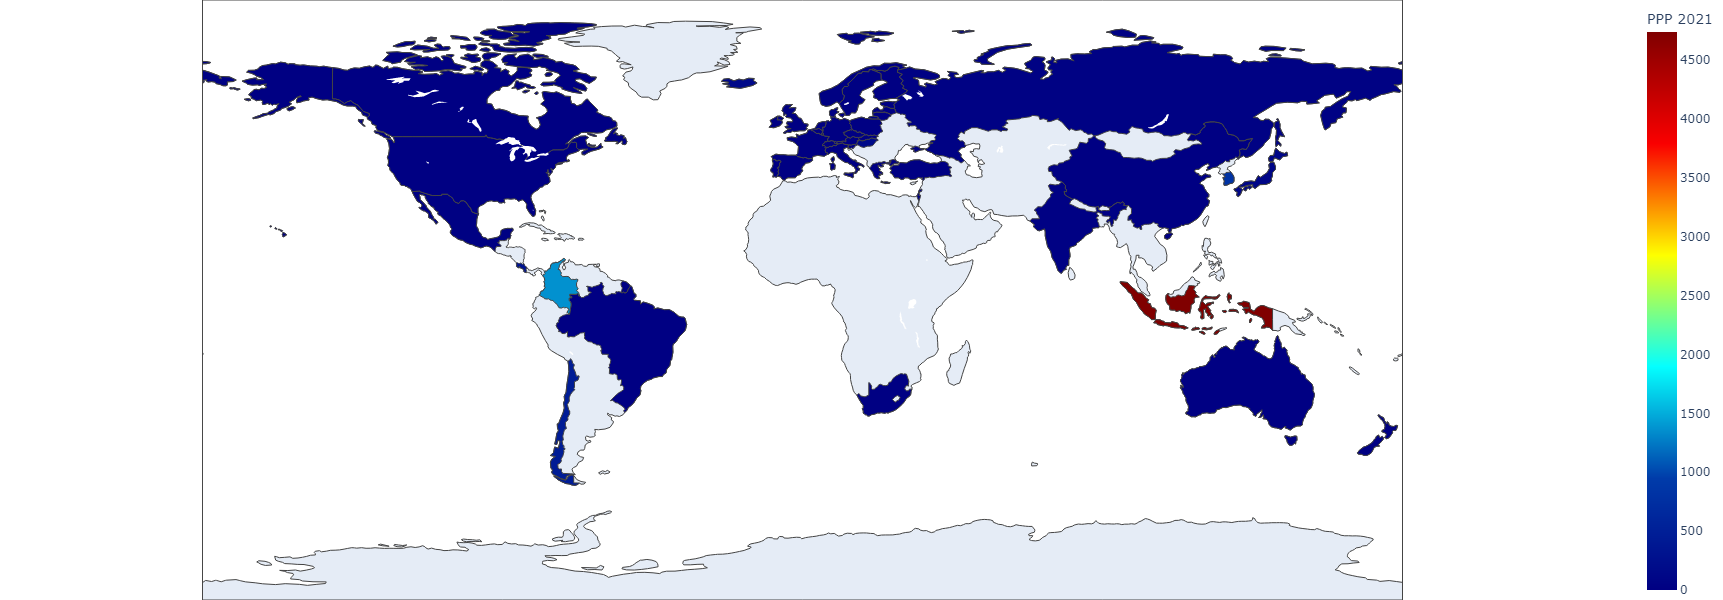

In [547]:
states_geojson = requests.get('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_1_states_provinces_lines.geojson').json()
fig = px.choropleth(data_frame=df_ppp,
                    locations=df_ppp.LOCATION, locationmode='ISO-3', 
                    color='Value',
                    labels={'Value':'PPP 2021'},
                    color_continuous_scale =px.colors.sequential.Jet,
                    title='PPP'
                   )

fig.update_layout(height=600, width=1600, margin={'r':0,'t':0,'l':0,'b':0})
fig.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1facc6b4e20>,
 'caps': [<matplotlib.lines.Line2D at 0x1facc6b5270>,
 'boxes': [<matplotlib.lines.Line2D at 0x1facc6b7eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x1facc633520>],
 'fliers': [<matplotlib.lines.Line2D at 0x1facc632f80>],
 'means': []}

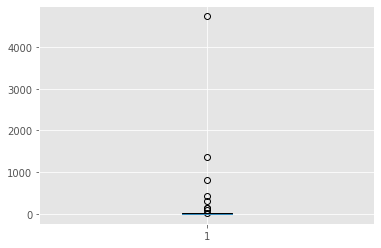

In [549]:
plt.boxplot(df_ppp.Value)

## Staggering Colormap by Quartiles
<ul>
    <li>Identify Quartiles</li>
    <li>Disect Sequential Colormap into 3 seperate Sequential Colormaps</li>
    <li>Plot each Quartile</li>
    <li>Combine into one choropleth</li>
    <li>Review and Adjust for mo
    
</ul>

In [550]:
df_ppp.sort_values('Value').count()

LOCATION    46
TIME        46
Value       46
dtype: int64

In [551]:
q3, q1 = np.percentile(df_ppp['Value'], [75, 25])
iqr = q3 - q1

In [552]:
print('<Q1')
print(q1)
print(df_ppp[df_ppp['Value'] < q1].count())
print('\nIQR')
print(df_ppp[df_ppp['Value'] < q3][df_ppp['Value'] > q1].count())
print('\n>Q3')
print(q3)
print(df_ppp[df_ppp['Value'] > q3].count())

<Q1
0.69588775
LOCATION    12
TIME        12
Value       12
dtype: int64

IQR
LOCATION    22
TIME        22
Value       22
dtype: int64

>Q3
10.87199575
LOCATION    12
TIME        12
Value       12
dtype: int64


C:\Users\Charles\AppData\Local\Temp\ipykernel_14276\2753806440.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [553]:
px.colors.sequential.Jet

['rgb(0,0,131)',
 'rgb(0,60,170)',
 'rgb(5,255,255)',
 'rgb(255,255,0)',
 'rgb(250,0,0)',
 'rgb(128,0,0)']

In [561]:
colorq1 = ['rgb(0,0,131)','rgb(0,60,170)']
coloriqr = ['rgb(0,60,170)','rgb(5,255,255)','rgb(255,255,0)','rgb(250,0,0)']
colorq3 = ['rgb(250,0,0)','rgb(128,0,0)']

In [562]:
q1mask = df_ppp[df_ppp['Value'] < q1]
iqrmask = df_ppp[df_ppp['Value'] < q3][df_ppp['Value'] > q1]
q3mask = df_ppp[df_ppp['Value'] > q3]

C:\Users\Charles\AppData\Local\Temp\ipykernel_14276\209257734.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



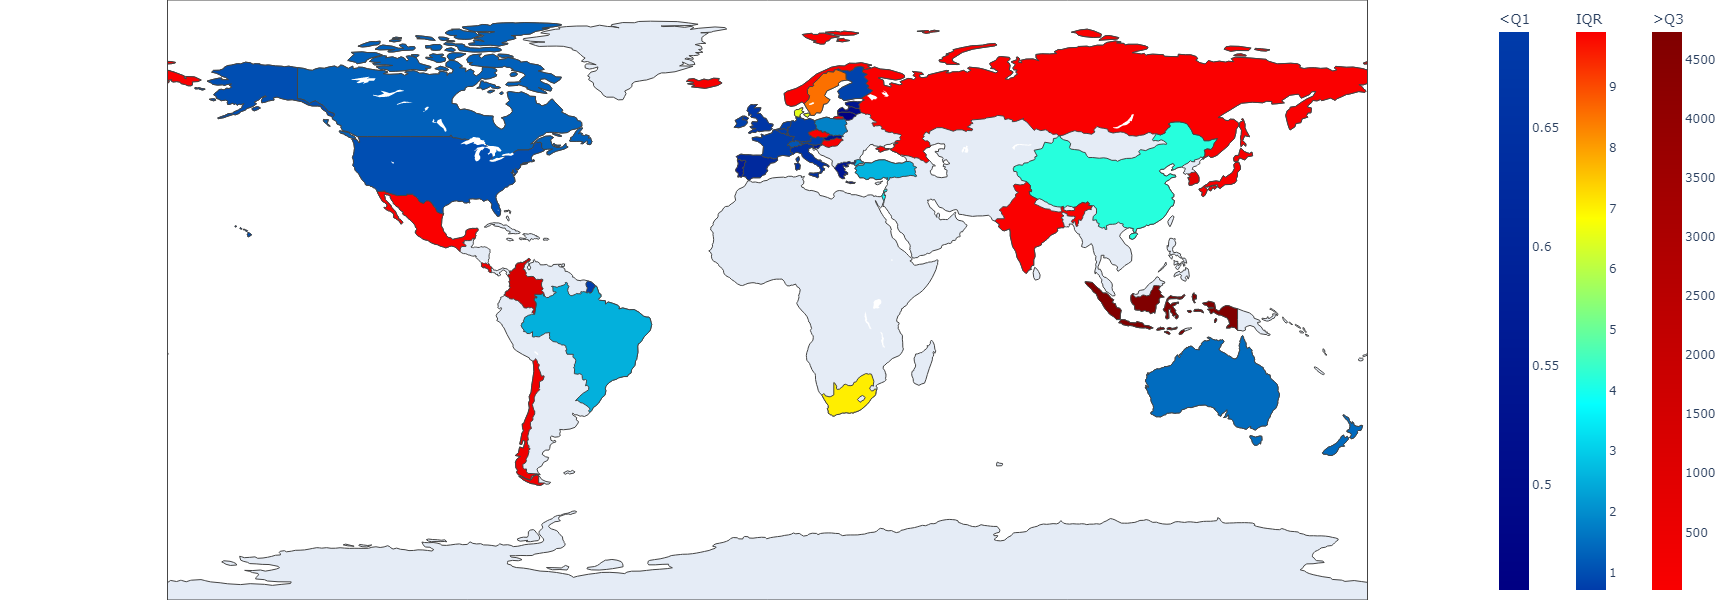

In [568]:
states_geojson = requests.get('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_1_states_provinces_lines.geojson').json()
fig = px.choropleth(data_frame=q1mask,
                    locations=q1mask.LOCATION, locationmode='ISO-3', 
                    color='Value',
                    labels={'Value':'<Q1'},
                    color_continuous_scale =colorq1,
                    title='PPP',
                    basemap_visible=True,
                   )
fig2 = px.choropleth(data_frame=iqrmask,
                    locations=iqrmask.LOCATION, locationmode='ISO-3', 
                    color=iqrmask.Value,
                    labels={'Value':'IQR'},
                    color_continuous_scale =coloriqr,
                    title='PPP',
                    basemap_visible=True,
                   )
fig3 = px.choropleth(data_frame=q3mask,
                    locations=q3mask.LOCATION, locationmode='ISO-3', 
                    color=q3mask.Value,
                    labels={'Value':'>Q3'},
                    color_continuous_scale = colorq3,
                    title='PPP',
                   )
# First we add the trace of the data to fig. This stores it to the Fig dictionary under fig['data'][idx] where idx is list of figs.
fig.add_trace(fig2.data[0])
# We access the layout to create another coloraxis based on coloraxis in fig2
fig.layout.coloraxis2 = fig2.layout.coloraxis
# We step through fig.__dict__ to the coloraxis of fig['data'] at position 1 and set it equal to the layout.coloraxis2 we created
fig['data'][1]['coloraxis'] = 'coloraxis2'

fig.add_trace(fig3.data[0])
fig.layout.coloraxis3 = fig3.layout.coloraxis
fig['data'][2]['coloraxis'] = 'coloraxis3'

# Adjusting coloraxis bar so all are visible
fig.layout.coloraxis.colorbar.x = +.97
fig.layout.coloraxis2.colorbar.x = +1.02
fig.layout.coloraxis3.colorbar.x = +1.07

fig.update_layout(height=600, width=1600, margin={'r':0,'t':0,'l':0,'b':0})
fig.show()

# FRED Exploration

In [ ]:
_dict = {}
for seri in res.index:
    _dict[seri] = Fred_handler.get_series(seri)
ppp_df = pd.concat(_dict, axis=1)
ppp_df.dropna(inplace=True)
id_to_country = res['title'].str.replace('Purchasing Power Parity, Share of World for ', '').to_dict()

In [ ]:
ppp_df.columns = [id_to_country[c] for c in ppp_df.columns]

In [86]:
ppp_df[ppp_df.index > '2019'].T

2020-01-01  2021-01-01  2022-01-01  \
Argentina                         0.608338    0.596150    0.589089   
Antigua and Barbuda               0.001928    0.001909    0.001881   
Belize                            0.002451    0.002410    0.002368   
Bolivia                           0.066823    0.066948    0.067072   
Brazil                            2.405373    2.378970    2.352519   
Barbados                          0.003728    0.003656    0.003597   
Canada                            1.318612    1.296312    1.273888   
Chile                             0.353299    0.352351    0.351518   
Colombia                          0.553496    0.554792    0.556080   
Caribbean                         0.232761    0.233480    0.234253   
Costa Rica                        0.064060    0.063622    0.063285   
Dominica                          0.000608    0.000612    0.000612   
Dominican Republic                0.144449    0.146466    0.148601   
Ecuador                           0.138956    0.136445    0.135399   
Grenada                           0.001274    0.001264    0.001260   
Guatemala                         0.108271    0.108495    0.108585   
Guyana                            0.009032    0.009142    0.010654   
Honduras                          0.036545    0.036590    0.036672   
Haiti                             0.014580    0.014296    0.014018   
Jamaica                           0.019200    0.018865    0.018585   
Mexico                            1.815672    1.787473    1.763276   
Nicaragua                         0.023362    0.022548    0.021881   
Panama                            0.081419    0.082980    0.084575   
Peru                              0.338018    0.339631    0.341221   
Paraguay                          0.068935    0.069403    0.069758   
St. Kitts and Nevis               0.001220    0.001214    0.001205   
St. Lucia                         0.001834    0.001825    0.001806   
El Salvador                       0.038884    0.038393    0.037908   
Suriname                          0.006494    0.006425    0.006331   
St. Vincent and the Grenadines    0.000960    0.000949    0.000938   
Trinidad and Tobago               0.031282    0.030915    0.030457   
Uruguay                           0.057888    0.057605    0.056765   
United States                    14.927590   14.673656   14.397238   

                                2023-01-01  2024-01-01  
Argentina                         0.586477    0.584366  
Antigua and Barbuda               0.001853    0.001825  
Belize                            0.002326    0.002283  
Bolivia                           0.067163    0.067245  
Brazil                            2.326388    2.296812  
Barbados                          0.003537    0.003478  
Canada                            1.251018    1.228397  
Chile                             0.350505    0.349211  
Colombia                          0.557102    0.558052  
Caribbean                         0.234817    0.235431  
Costa Rica                        0.063062    0.063016  
Dominica                          0.000603    0.000591  
Dominican Republic                0.150669    0.152745  
Ecuador                           0.134024    0.132651  
Grenada                           0.001255    0.001248  
Guatemala                         0.108538    0.108427  
Guyana                            0.012983    0.012941  
Honduras                          0.036777    0.036907  
Haiti                             0.013739    0.013464  
Jamaica                           0.018319    0.018071  
Mexico                            1.741317    1.721538  
Nicaragua                         0.021335    0.020900  
Panama                            0.086161    0.087764  
Peru                              0.342336    0.342954  
Paraguay                          0.070101    0.070324  
St. Kitts and Nevis               0.001194    0.001184  
St. Lucia                         0.001770    0.001734  
El Salvador                       0.037410    0.036914 

In [47]:
Fred_handler.get_series('PPPTTLMXA618NUPN')

1950-01-01    0.003234
1951-01-01    0.003681
1952-01-01    0.003899
1953-01-01    0.003940
1954-01-01    0.004251
                ...   
2006-01-01    7.646234
2007-01-01    7.819646
2008-01-01    8.012788
2009-01-01    8.405204
2010-01-01    8.635244
Length: 61, dtype: float64

In [35]:
Fred_handler.search('Japan exchange', order_by='popularity')

id realtime_start realtime_end  \
series id                                                        
DEXJPUS                    DEXJPUS     2022-06-14   2022-06-14   
EXJPUS                      EXJPUS     2022-06-14   2022-06-14   
NIKKEI225                NIKKEI225     2022-06-14   2022-06-14   
TWEXB                        TWEXB     2022-06-14   2022-06-14   
DTWEXM                      DTWEXM     2022-06-14   2022-06-14   
...                            ...            ...          ...   
DSAMRIFCERJP          DSAMRIFCERJP     2022-06-14   2022-06-14   
PLOGINJPA623NUPN  PLOGINJPA623NUPN     2022-06-14   2022-06-14   
M0538BUSM533NNBR  M0538BUSM533NNBR     2022-06-14   2022-06-14   
DSAMRIAOAERJP        DSAMRIAOAERJP     2022-06-14   2022-06-14   
M0538AUSM533NNBR  M0538AUSM533NNBR     2022-06-14   2022-06-14   

                                                              title  \
series id                                                             
DEXJPUS              Japanese Yen to U.S. Dollar Spot Exchange Rate   
EXJPUS               Japanese Yen to U.S. Dollar Spot Exchange Rate   
NIKKEI225                          Nikkei Stock Average, Nikkei 225   
TWEXB             Trade Weighted U.S. Dollar Index: Broad, Goods...   
DTWEXM            Nominal Major Currencies U.S. Dollar Index (Go...   
...                                                             ...   
DSAMRIFCERJP      Exchange Rate Adjusted Changes of Domestic Deb...   
PLOGINJPA623NUPN    Price Level of Government Consumption for Japan   
M0538BUSM533NNBR   Raw Silk, Total Visible Stocks for United States   
DSAMRIAOAERJP     Exchange Rate Adjusted Changes of Domestic Deb...   
M0538AUSM533NNBR   Raw Silk, Total Visible Stocks for United States   

                 observation_start observation_end                 frequency  \
series id                                                                      
DEXJPUS                 1971-01-04      2022-06-10                     Daily   
EXJPUS                  1971-01-01      2022-05-01                   Monthly   
NIKKEI225               1949-05-16      2022-06-14              Daily, Close   
TWEXB                   1995-01-04      2020-01-01  Weekly, Ending Wednesday   
DTWEXM                  1973-01-02      2019-12-31                     Daily   
...                            ...             ...                       ...   
DSAMRIFCERJP            1998-01-01      2021-10-01                 Quarterly   
PLOGINJPA623NUPN        1950-01-01      2010-01-01                    Annual   
M0538BUSM533NNBR        1930-07-01      1941-06-01     Monthly, End of Month   
DSAMRIAOAERJP           1998-01-01      2021-10-01                 Quarterly   
M0538AUSM533NNBR        1923-01-01      1931-12-01     Monthly, End of Month   

                 frequency_short  \
series id                          
DEXJPUS                        D   
EXJPUS                         M   
NIKKEI225                      D   
TWEXB                          W   
DTWEXM                         D   
...                          ...   
DSAMRIFCERJP                   Q   
PLOGINJPA623NUPN               A   
M0538BUSM533NNBR               M   
DSAMRIAOAERJP                  Q   
M0538AUSM533NNBR               M   

                                                              units  \
series id                                                             
DEXJPUS                             Japanese Yen to One U.S. Dollar   
EXJPUS                              Japanese Yen to One U.S. Dollar   
NIKKEI225                                                     Index   
TWEXB                                            Index Jan 1997=100   
DTWEXM                                           Index Mar 1973=100   
...                                                             ...   
DSAMRIFCERJP                                 Millions of US Dollars   
PLOGINJPA623NUPN   PPP of Government Consumption over Exchange Rate   
M0538BUSM533NNBR  Thousands o

In [36]:
jpn_yen = ['DEXJPUS', 'EXJPUS']

In [37]:
currency = {}
for i in jpn_yen:
    currency[i] = Fred_handler.get_series(i)

In [38]:
yen_df = pd.concat(currency, axis=1)

In [39]:
yen_df.dropna()

DEXJPUS    EXJPUS
1971-02-01   357.67  357.5450
1971-03-01   357.63  357.5187
1971-04-01   357.49  357.5032
1971-06-01   357.46  357.4118
1971-07-01   357.40  357.4043
...             ...       ...
2021-11-01   114.19  113.9650
2021-12-01   112.82  113.8329
2022-02-01   114.77  115.2763
2022-03-01   114.87  118.5774
2022-04-01   122.60  126.3743

[397 rows x 2 columns]

## Searching average wage